<a href="https://colab.research.google.com/github/AilingLiu/TMDB_Box_Office_Prediction/blob/master/tmdb_box_office_revenue_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Competition details

`https://www.kaggle.com/c/tmdb-box-office-prediction/data`


# Overview



---


In this competition, you're presented with metadata on over 7,000 past films 
from The Movie Database to try and predict their overall worldwide box office revenue. Data points provided include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries. You can collect other publicly available data to use in your model predictions, but in the spirit of this competition, use only data that would have been available before a movie's release.

# Set up

In [0]:
import sys
sys.version_info >= (3, 5) # evaluate python version is 3.5 and later

import sklearn
sklearn.__version__ >= '0.20' # evaluate sklearn version is 0.2 and later

# common imports
import os
import numpy as np

# set up the display
import pandas as pd
pd.set_option('max_rows', 101)
pd.set_option('max_colwidth', 100)

# setting figure
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# figure saving location
PROJECT_ROOT_DIR = '.'
PROJECT_ID = 'tmdb_movie_revenue'
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', PROJECT_ID)
os.makedirs(IMAGE_PATH, exist_ok=True)

def save_fig(image_name, save_in=IMAGE_PATH, tight_layout=True, dpi=300, image_extension='png'):
  path=os.path.join(IMAGE_PATH, image_name + '.' + image_extension)
  print('Saving Picture: ', image_name)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=image_extension, dpi=dpi)



# Get Data

In [0]:
URL_PATH = 'https://github.com/AilingLiu/TMDB_Box_Office_Prediction/raw/master/tmdb-box-office-prediction.zip'
DATA_PATH = os.path.join('datasets', PROJECT_ID)

from zipfile import ZipFile
import urllib

def fetch_data(url=URL_PATH, to_local=DATA_PATH):
  zip_path = os.path.join(DATA_PATH, 'tmdb_movie_revenue.zip')
  if not os.path.isdir(to_local):
    os.makedirs(to_local)
  urllib.request.urlretrieve(URL_PATH, zip_path)
  zip_=ZipFile(zip_path, 'r')
  zip_.extractall(DATA_PATH)
  zip_.close()

In [0]:
fetch_data()

In [0]:
# quick look of csv data in shell command
#!head -n 2 datasets/tmdb_movie_revenue/train.csv

In [0]:
import pandas as pd

def load_data(train_set=True, data_path=DATA_PATH):
  if train_set:
    path=os.path.join(data_path, 'train.csv')
  else:
    path=os.path.join(data_path, 'test.csv')
  return pd.read_csv(path, index_col='id')

In [6]:
movies=load_data()
movies.head(2)

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,,
1,"[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1i...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the Internet,"" is shot by an unknown assailant, Jacob an...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-...","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Violated.,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot...","[{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': ...","[{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071...",12314651
2,"[{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm1...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'i...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and on her way to Genovia to take up her duties as pri...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she's got 30 days!,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriag...","[{'cast_id': 1, 'character': 'Mia Thermopolis', 'credit_id': '52fe43fe9251416c7502561f', 'gender...","[{'credit_id': '52fe43fe9251416c7502563d', 'department': 'Directing', 'gender': 2, 'id': 1201, '...",95149435


In [0]:
#!head -n 2 'datasets/tmdb_movie_revenue/train.csv'

In [0]:
# Some columns contain sort of json format in string format. We can use the pandas `converter` trick to cast string to whatever format we want

def string_to_list(x):
  return eval(x) if x and x != '#N/A' else []

io_columns = [
              'belongs_to_collection',
              'genres',
              'production_companies',
              'production_countries',
              'spoken_languages',
              'Keywords',
              'cast',
              'crew'
]


io_params = {
    'index_col': 'id',
    'converters': {col: string_to_list for col in io_columns}
    
}

def load_data(train_set=True, data_path=DATA_PATH, params=io_params):
  if train_set:
    path=os.path.join(data_path, 'train.csv')
  else:
    path=os.path.join(data_path, 'test.csv')
  return pd.read_csv(path, **io_params)

In [8]:
movies = load_data()
movies.head(3)

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,,
1,"[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1i...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the Internet,"" is shot by an unknown assailant, Jacob an...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-...","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Violated.,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot...","[{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': ...","[{'credit_id': '59ac067c92514107af02c8c8', 'department': 'Directing', 'gender': 0, 'id': 1449071...",12314651
2,"[{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm1...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'i...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and on her way to Genovia to take up her duties as pri...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she's got 30 days!,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriag...","[{'cast_id': 1, 'character': 'Mia Thermopolis', 'credit_id': '52fe43fe9251416c7502561f', 'gender...","[{'credit_id': '52fe43fe9251416c7502563d', 'department': 'Directing', 'gender': 2, 'id': 1201, '...",95149435
3,[],3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, a talented young drummer begins to pursue perfecti...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Ri...","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conserva...","[{'cast_id': 5, 'character': 'Andrew Neimann', 'credit_id': '52fe4ef7c3a36847f82b3fc3', 'gender'...","[{'credit_id': '54d5356ec3a3683ba0000039', 'department': 'Production', 'gender': 1, 'id': 494, '...",13092000


In [0]:
movies.iloc[:3, 0] # Now we can see the `blongs_to_collection` format become list of dictionaries, instead of string, and nan is empty list.

id
1    [{'id': 313576, 'name': 'Hot Tub Time Machine ...
2    [{'id': 107674, 'name': 'The Princess Diaries ...
3                                                   []
Name: belongs_to_collection, dtype: object

# Quick view of data structure

In [0]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 1 to 3000
Data columns (total 22 columns):
belongs_to_collection    3000 non-null object
budget                   3000 non-null int64
genres                   3000 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     3000 non-null object
production_countries     3000 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         3000 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords                 3000 non-null object
cast               

this data has only 3000 entries, quite a small dataset. There are 22 columns, including the target column `revenue`. It has four numerical attributes, and the remaining attributes are object type. 

In [0]:
movies.describe()

,budget,popularity,runtime,revenue
count,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,2.253133e+07,8.463274,107.856571,6.672585e+07
std,3.702609e+07,12.104000,22.086434,1.375323e+08
min,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3.800000e+08,294.337037,338.000000,1.519558e+09


Saving Picture:  scatter_matrix_of_movies


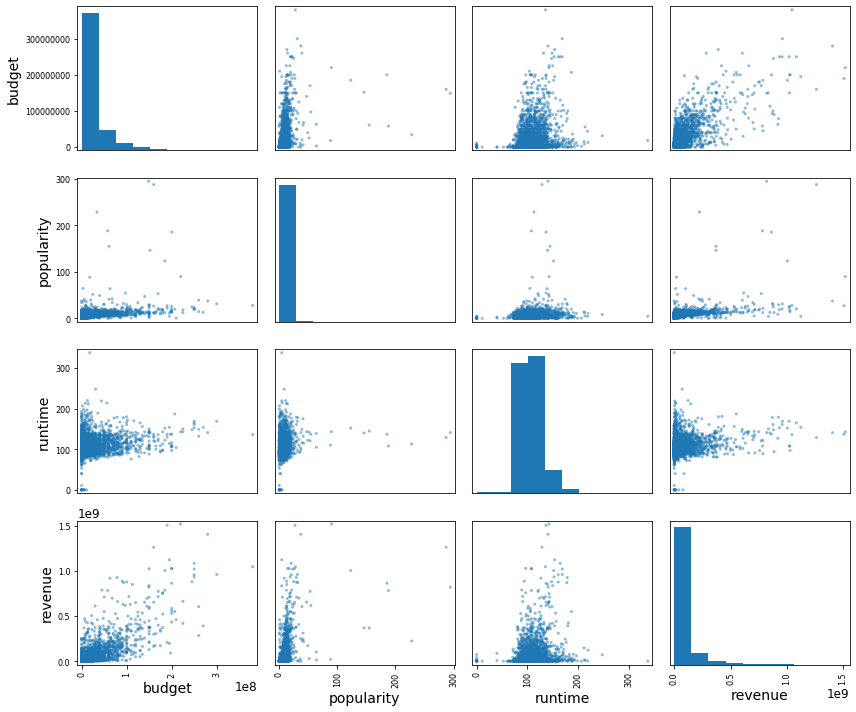

In [0]:
from pandas.plotting import scatter_matrix

scatter_matrix(movies, figsize=(12, 10));
save_fig('scatter_matrix_of_movies')

**`budget`** and **`revenue`** appear to have pretty positive linear relation. the more budget that the movie spent, the more revenue it gaine. Most of times are true especially for commercial movies. But there are exceptions nowadays. There are data scattered far from the main area.

Popularity is stable regardless of revenue and popularity increases. However, we can also see that the images has been reduced/squeezed by the outliers from 30 and beyond. We need to clean the outliers to have a closer look on this attributes. **`runtime`** is normally distributed. We can find out the average runtime for most of the movies from this dataset. 

Lastly, notice that the unit of popularity and runtime (from 0 to 300) is much less than budget and revenue (million). We can change that as well for buiding the regression model.

# Test set

Let's set aside test set so we will not have visibility on the patterns that might seem interesting in test set and get overfitting in our models. 

In [29]:
from sklearn.model_selection import train_test_split

dev_set, val_set = train_test_split(movies, test_size=0.3, random_state=42)
print(f'shape of dev set: {dev_set.shape}')
print(f'\nshape of validation set: {val_set.shape}')

shape of dev set: (2100, 22)

shape of validation set: (900, 22)


# Analysis of data with visualisation

In [10]:
# We can take a quick look at the simple dataset for a quick start (the ones not in io_params, not in list of dictionaries.)

potential_col = dev_set.columns.difference(io_columns)
potential_col

Index(['budget', 'homepage', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'release_date', 'revenue',
       'runtime', 'status', 'tagline', 'title'],
      dtype='object')

Total different languages: 33


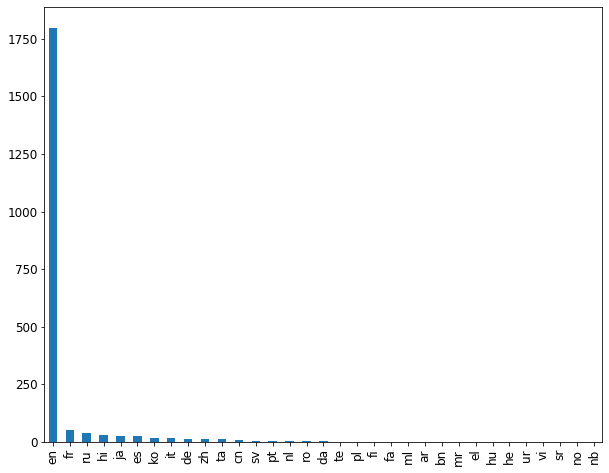

In [0]:
# Original_language should be low cardinality. Good start to look at
print('Total different languages: {}'.format(dev_set.original_language.nunique()))
dev_set['original_language'].value_counts().plot(kind='bar', figsize=(10, 8));

  adjustable: {'box', 'datalim'}
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float
  anchor: 2-tuple of floats or {'C', 'SW', 'S', 'SE', ...}
  animated: bool
  aspect: {'auto', 'equal'} or num
  autoscale_on: bool
  autoscalex_on: bool
  autoscaley_on: bool
  axes_locator: Callable[[Axes, Renderer], Bbox]
  axisbelow: bool or 'line'
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: [(`~matplotlib.path.Path`, `.Transform`) | `.Patch` | None]
  contains: callable
  facecolor: color
  fc: color
  figure: `.Figure`
  frame_on: bool
  gid: str
  in_layout: bool
  label: object
  navigate: bool
  navigate_mode: unknown
  path_effects: `.AbstractPathEffect`
  picker: None or bool or float or callable
  position: [left, bottom, width, height] or `~matplotlib.transforms.Bbox`
  rasterization_zorder: float or None
  rasterized: bool or None
  sketch_params: (scale: float, length: float, randomness: float)
  snap: bo

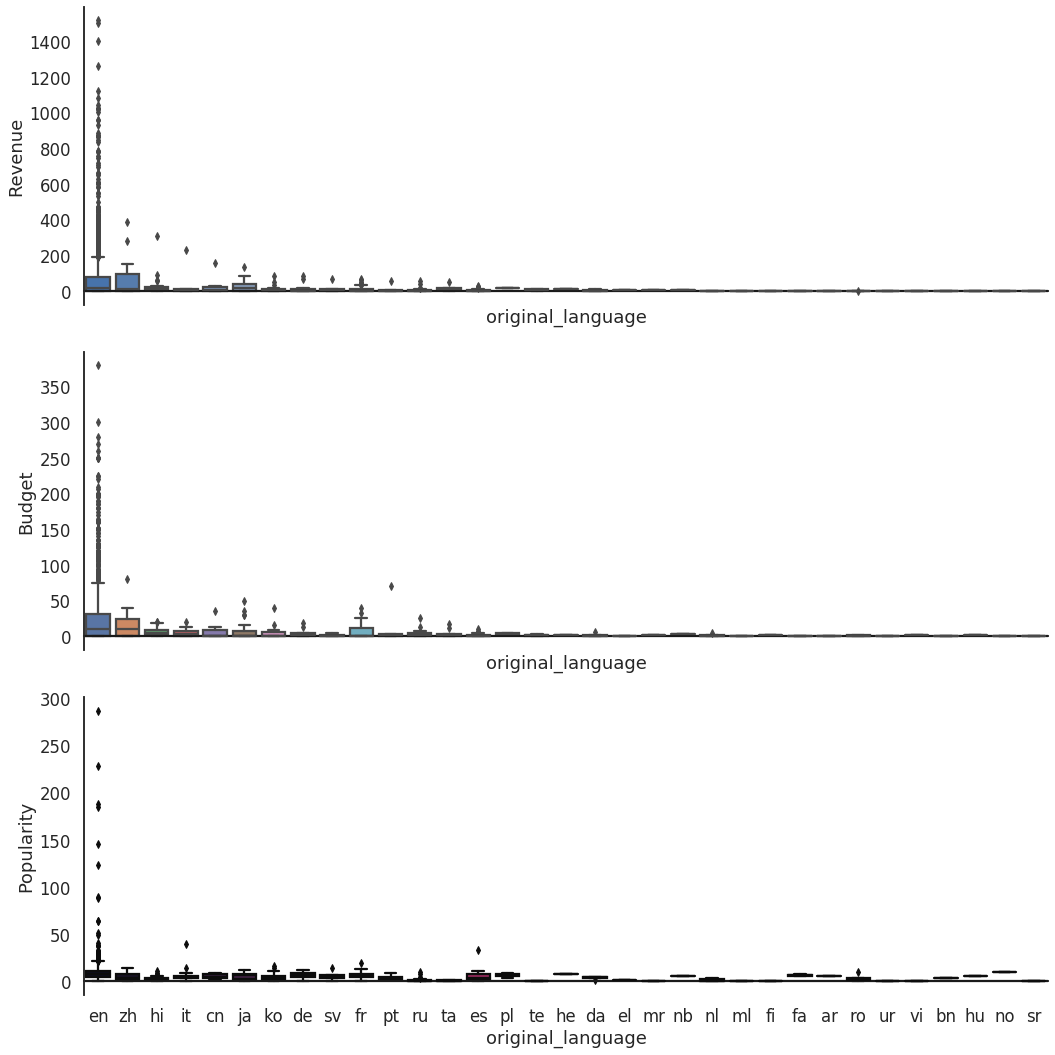

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", context="talk")

# Set up the matplotlib figure
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

x=dev_['original_language']
y1=dev_['revenue']/1000000
y2=dev_['budget']/1000000
y3=dev_['popularity']

# revenue plot
sns.boxplot(x=x, y=y1, palette="vlag", ax=ax1);
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Revenue")

# budget plot
sns.boxplot(x=x, y=y2, palette="deep", ax=ax2);
ax2.axhline(0, color="k", clip_on=False)
ax2.set_ylabel("Budget")

# popularity plot
sns.boxplot(x=x, y=y3, palette="rocket", ax=ax3);
ax3.axhline(0, color="k", clip_on=False)
ax3.set_ylabel("Popularity")

# Finalize the plot
sns.despine(bottom=True);
plt.setp(f.axes);
plt.tight_layout(h_pad=2)
save_fig('box_plot_languaes_budget_revenue_popularity')

More than half of those languages do not have enough data to be represensitive. We can consider to group the minority as an independent group. The group of `revenue`, `budget` and `popularity` also see lots of outliers lurking at the high end in the `English` category. Other language category are more centered.

In [0]:
# Let's take a look at the status
dev_set.status.value_counts()

Released    2098
Rumored        2
Name: status, dtype: int64

In [0]:
dev_set[dev_set.status == 'Rumored']

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,,
610,"[{'id': 144200, 'name': 'Swan Princess Series'...",0,"[{'id': 14, 'name': 'Fantasy'}, {'id': 16, 'na...",NaN,tt0120254,en,The Swan Princess: Escape from Castle Mountain,The first wedding anniversary of Princess Odet...,5.121309,/oTEgvTpAIugS7OH6oIoVZkmV3C3.jpg,[],[],1/1/97,71.0,"[{'iso_639_1': 'da', 'name': 'Dansk'}, {'iso_6...",Rumored,It Will Take All Her Magic to Rescue Her Friends!,The Swan Princess: Escape from Castle Mountain,"[{'id': 3071, 'name': 'prince'}, {'id': 4456, ...","[{'cast_id': 2, 'character': 'Odette (voice)',...","[{'credit_id': '52fe488bc3a36847f816cfd3', 'de...",273644
1008,[],0,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt1860180,en,Billy Gardell: Halftime,"Billy Gardell, the star of CBS' hit comedy ""Mi...",0.007877,/3ypM4bwZTvUfXiKJTs0BaEZuBhe.jpg,[],"[{'iso_3166_1': 'US', 'name': 'United States o...",2/5/11,60.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Rumored,NaN,Billy Gardell: Halftime,[],"[{'cast_id': 9, 'character': 'Himself', 'credi...","[{'credit_id': '52fe4be1c3a368484e19d265', 'de...",60


# clean data

In [0]:
# clean up the list of dictionary format
dev_set.head(3)

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,,
612,[],8575000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]",NaN,tt4016934,ko,아가씨,"1930s Korea, in the period of Japanese occupation, a new girl (Sookee) is hired as a handmaiden ...",16.727405,/wvzfK5QR6dGLwND8MCzWjsQWG4Q.jpg,"[{'name': 'CJ Entertainment', 'id': 7036}, {'name': 'Moho Film', 'id': 34725}, {'name': 'Yong Fi...","[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",6/1/16,145.0,"[{'iso_639_1': 'ja', 'name': '日本語'}, {'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,Never did they expect to get into a controversial relationship...,The Handmaiden,"[{'id': 293, 'name': 'female nudity'}, {'id': 3202, 'name': 'con man'}, {'id': 3430, 'name': 'pi...","[{'cast_id': 3, 'character': 'Lady Hideko', 'credit_id': '564beaf19251414dd1005414', 'gender': 1...","[{'credit_id': '54056d0b0e0a2658f100c167', 'department': 'Directing', 'gender': 2, 'id': 10099, ...",1983204
531,"[{'id': 366444, 'name': 'Demetrius Filmreihe', 'poster_path': None, 'backdrop_path': None}]",4100000,"[{'id': 18, 'name': 'Drama'}]",NaN,tt0046247,en,The Robe,Marcellus is a tribune in the time of Christ. He is in charge of the group that is assigned to c...,3.826281,/v3Bf2Tfbgdj5fOKbIfQvH7YPlFD.jpg,"[{'name': 'Twentieth Century Fox Film Corporation', 'id': 306}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",9/16/53,135.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The first motion picture in CinemaScope--the modern miracle you see without glasses!,The Robe,"[{'id': 3571, 'name': 'crucifixion'}, {'id': 5049, 'name': 'ancient rome'}]","[{'cast_id': 1, 'character': 'Marcellus Gallio', 'credit_id': '52fe4603c3a368484e07be07', 'gende...","[{'credit_id': '52fe4603c3a368484e07be21', 'department': 'Directing', 'gender': 2, 'id': 33064, ...",36000000
2788,[],80000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}, {'id': 878, 'name': 'Science Fict...",NaN,tt1037705,en,The Book of Eli,"A post-apocalyptic tale, in which a lone man fights his way across America in order to protect a...",14.398530,/qL3FnEug9DyBcaBXVb0oT3DJMJu.jpg,"[{'name': 'Alcon Entertainment', 'id': 1088}, {'name': 'Silver Pictures', 'id': 1885}]","[{'iso_3166_1': 'US', 'name': 'United States of America'}]",1/14/10,118.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Some will kill to have it. He will kill to protect it.,The Book of Eli,"[{'id': 3096, 'name': 'book'}, {'id': 4458, 'name': 'post-apocalyptic'}, {'id': 4565, 'name': 'd...","[{'cast_id': 1, 'character': 'Eli', 'credit_id': '52fe43e9c3a368484e005825', 'gender': 2, 'id': ...","[{'credit_id': '52fe43e9c3a368484e0058ad', 'department': 'Camera', 'gender': 2, 'id': 36, 'job':...",157107755


In [0]:
from pandas.io.json import json_normalize

list_to_dict = lambda x: x[0] if x and isinstance(x, list) else {}

def split_json_to_cols(col_names=io_columns, data=dev_set):
  newdata = data.copy()

  for colname in col_names:
    column_unlist = newdata[colname].apply(list_to_dict)
    df = json_normalize(column_unlist)
    df.index = data.index
    new_df_names = [colname + '_' + name for name in df.columns]
    df.columns = new_df_names

    # change the column '.._id' to object type instead of float
    if df.columns.str.contains('_id').any():
      id_ind = np.where(df.columns.str.contains('_id'))[0]
      df.iloc[:, id_ind] = df.iloc[:, id_ind].astype('object')

    newdata.drop(colname, axis=1, inplace=True)
    #newdata.merge(df, left_index=True, right_index=True)
    newdata=pd.concat([newdata, df], axis=1)

  return newdata

In [28]:
clean_dev = split_json_to_cols()
clean_test = split_json_to_cols(data=val_set)

print(f'shape of dataset after cleaning: {clean_dev.shape}')
display(clean_dev.head(3))

shape of dataset after cleaning: (2100, 43)


,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,revenue,belongs_to_collection_id,belongs_to_collection_name,belongs_to_collection_poster_path,belongs_to_collection_backdrop_path,genres_id,genres_name,production_companies_name,production_companies_id,production_countries_iso_3166_1,production_countries_name,spoken_languages_iso_639_1,spoken_languages_name,Keywords_id,Keywords_name,cast_cast_id,cast_character,cast_credit_id,cast_gender,cast_id,cast_name,cast_order,cast_profile_path,crew_credit_id,crew_department,crew_gender,crew_id,crew_job,crew_name,crew_profile_path
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
612,8575000,NaN,tt4016934,ko,아가씨,"1930s Korea, in the period of Japanese occupation, a new girl (Sookee) is hired as a handmaiden ...",16.727405,/wvzfK5QR6dGLwND8MCzWjsQWG4Q.jpg,6/1/16,145.0,Released,Never did they expect to get into a controversial relationship...,The Handmaiden,1983204,NaN,NaN,NaN,NaN,53,Thriller,CJ Entertainment,7036,KR,South Korea,ja,日本語,293,female nudity,3,Lady Hideko,564beaf19251414dd1005414,1.0,123664,Kim Min-hee,0.0,/3MNC2vPOIjYzhATMslPV1dypOJs.jpg,54056d0b0e0a2658f100c167,Directing,2.0,10099,Director,Park Chan-wook,/oITKgh5vsTZvW2a5sMwgSFSfJDb.jpg
531,4100000,NaN,tt0046247,en,The Robe,Marcellus is a tribune in the time of Christ. He is in charge of the group that is assigned to c...,3.826281,/v3Bf2Tfbgdj5fOKbIfQvH7YPlFD.jpg,9/16/53,135.0,Released,The first motion picture in CinemaScope--the modern miracle you see without glasses!,The Robe,36000000,366444,Demetrius Filmreihe,None,None,18,Drama,Twentieth Century Fox Film Corporation,306,US,United States of America,en,English,3571,crucifixion,1,Marcellus Gallio,52fe4603c3a368484e07be07,2.0,5341,Richard Burton,0.0,/fRoBAQQP9sfnIYuqw546yFs3qKn.jpg,52fe4603c3a368484e07be21,Directing,2.0,33064,Director,Henry Koster,/tihVLXBhbDiif3u3DyZI5HJ8PZB.jpg
2788,80000000,NaN,tt1037705,en,The Book of Eli,"A post-apocalyptic tale, in which a lone man fights his way across America in order to protect a...",14.398530,/qL3FnEug9DyBcaBXVb0oT3DJMJu.jpg,1/14/10,118.0,Released,Some will kill to have it. He will kill to protect it.,The Book of Eli,157107755,NaN,NaN,NaN,NaN,28,Action,Alcon Entertainment,1088,US,United States of America,en,English,3096,book,1,Eli,52fe43e9c3a368484e005825,2.0,5292,Denzel Washington,0.0,/khMf8LLTtppUwuZqqnigD2nAy26.jpg,52fe43e9c3a368484e0058ad,Camera,2.0,36,Director of Photography,Don Burgess,None


In [30]:
# have a safe check on the val test cleaning as well
display(clean_test.head(2))

,budget,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,runtime,status,tagline,title,revenue,belongs_to_collection_id,belongs_to_collection_name,belongs_to_collection_poster_path,belongs_to_collection_backdrop_path,genres_id,genres_name,production_companies_name,production_companies_id,production_countries_iso_3166_1,production_countries_name,spoken_languages_iso_639_1,spoken_languages_name,Keywords_id,Keywords_name,cast_cast_id,cast_character,cast_credit_id,cast_gender,cast_id,cast_name,cast_order,cast_profile_path,crew_credit_id,crew_department,crew_gender,crew_id,crew_job,crew_name,crew_profile_path
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1802,3500000,NaN,tt0165494,en,Ringmaster,"Jerry Springer stars as more or less himself, the host of a raunchy, controversial and popular L...",0.556435,/gbLOUw9pmCF6cC0QbQHHACywAqg.jpg,11/25/98,90.0,Released,NaN,Ringmaster,9247881,NaN,NaN,NaN,NaN,35,Comedy,Artisan Entertainment,2188,US,United States of America,en,English,3741,talk show,3,Jerry Farrelly,52fe46539251416c91050d7f,0.0,94743,Jerry Springer,0.0,/uwlqChyS9RTqXWObp3smWqzOBuA.jpg,52fe46539251416c91050d75,Directing,2.0,109004,Director,Neil Abramson,None
1191,0,NaN,tt0089984,en,He-Man and She-Ra: The Secret of the Sword,"After experiencing traumatic nightmares of a time now past, the Sorceress summons Prince Adam an...",2.087446,/ly1EIJLXe4REIlBtFLFbDQfRHAe.jpg,1/1/85,100.0,Released,NaN,He-Man and She-Ra: The Secret of the Sword,7,NaN,NaN,NaN,NaN,16,Animation,Filmation Associates,1506,US,United States of America,en,English,1400,swordplay,13,Prince Adam / He-Man / Beast Man (voice),52fe47d59251416c750a6f25,2.0,176053,John Erwin,0.0,None,52fe47d59251416c750a6ef7,Directing,0.0,33534,Director,Gwen Wetzler,None


In [31]:
# Now let's look again how many attributes we have
clean_dev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2100 entries, 612 to 861
Data columns (total 43 columns):
budget                                 2100 non-null int64
homepage                               673 non-null object
imdb_id                                2100 non-null object
original_language                      2100 non-null object
original_title                         2100 non-null object
overview                               2092 non-null object
popularity                             2100 non-null float64
poster_path                            2099 non-null object
release_date                           2100 non-null object
runtime                                2098 non-null float64
status                                 2100 non-null object
tagline                                1659 non-null object
title                                  2100 non-null object
revenue                                2100 non-null int64
belongs_to_collection_id               425 non-null o

`belongs_to_collection` has lots of null values in each of its sub attribute. Have a check if we can conver this attribute to a binary indicator of whether the movie belongs to collection (1) or not (0). Be careful of introducing bias of the unknown instance.

Next step, we can start to use some of the potential attributes to build a model.